### $\textbf{MIE 1613 Term Project}$

### $\textit{Interest Rate Modelling with Applications to Mortgage Markets}$

#### $\textbf{David Islip}$



In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import re 

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from arch.univariate import GARCH, Normal, ZeroMean, StudentsT
from itertools import product 
from arch.bootstrap import MCS
from arch import arch_model
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import quandl
import pickle 

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

%matplotlib inline
rc('text', usetex=True)

In [2]:
#Read in the data
TD = pd.read_csv('IO Files\TD_Forecast.csv')
yield_curve = pd.read_csv('IO Files\yield_curves_update.csv')
yield_curve.Date = pd.to_datetime(yield_curve.Date)
yield_curve[yield_curve.Date <= '2020-04-01' ]
yield_curve.drop(' ', axis = 1, inplace = True)

In [3]:
benchmarks = quandl.get(["BOC/V39079", "BOC/V39065","BOC/V39051","BOC/V39053","BOC/V39055","BOC/V39056"],api_key='xY-nMTUQzLJNXPS6Nfyv').reindex()
benchmarks.dropna(inplace = True)
benchmarks.columns = [ 'Overnight Target Rate ', '3-mth T-Bill Rate ','2-yr Govt. Bond Yield ', '5-yr Govt. Bond Yield ','10-yr Govt. Bond Yield ', '30-yr Govt. Bond Yield ']
benchmarks.columns = [i.strip() for i in benchmarks.columns]
benchmarks.reset_index(inplace=True)

### Data Cleaning

In [4]:
TD.columns = [i.strip() for i in TD.columns]
TD = TD.drop(['Overnight Target Rate'], axis = 1)
TD

,Year,Quarter,3-mth T-Bill Rate,2-yr Govt. Bond Yield,5-yr Govt. Bond Yield,10-yr Govt. Bond Yield,30-yr Govt. Bond Yield,10-yr-2-yr Govt Spread,Quarter End Date
0,2020,Q1,0.0040,0.0040,0.0050,0.0065,0.0100,0.0025,03/31/2020
1,2020,Q2,0.0015,0.0050,0.0060,0.0075,0.0105,0.0031,06/30/2020
2,2020,Q3,0.0015,0.0065,0.0075,0.0090,0.0115,0.0025,09/30/2020
3,2020,Q4,0.0015,0.0080,0.0090,0.0105,0.0130,0.0025,12/31/2020
4,2021,Q1,0.0015,0.0100,0.0110,0.0125,0.0150,0.0025,03/31/2021
5,2021,Q2,0.0028,0.0120,0.0130,0.0145,0.0170,0.0025,06/30/2021
6,2021,Q3,0.0053,0.0135,0.0145,0.0160,0.0185,0.0025,09/30/2021
7,2021,Q4,0.0078,0.0150,0.0160,0.0175,0.0200,0.0025,12/31/2021


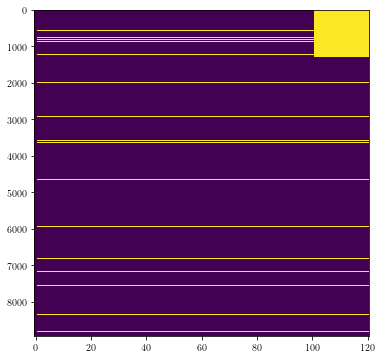

In [5]:
#### Investigate Missing Values
plt.figure(figsize = (6,6))
plt.imshow(yield_curve == 0,aspect='auto');
#yield_curve = yield_curve.replace(miss, 0.0);

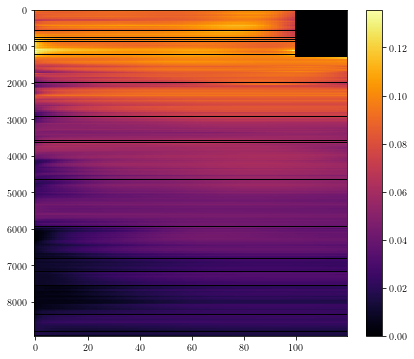

In [6]:
#Check if there are any columns that are not numeric
for i in range(1, len(yield_curve.columns)):
    if yield_curve.iloc[:,i].dtype != 'float64':
        print(yield_curve.iloc[:,i].dtype)
        break
plt.figure(figsize = (7,6))
plt.imshow(yield_curve.iloc[:,1:],aspect='auto',  cmap='inferno');
plt.colorbar();

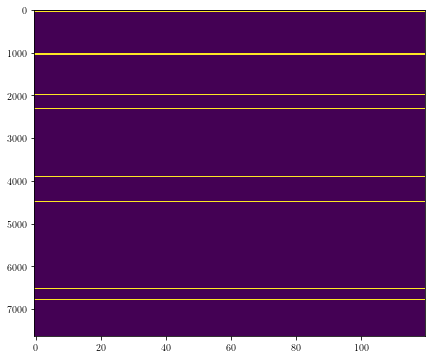

In [7]:
yield_curve.iloc[0:1306];

plt.figure(figsize = (7,6))
plt.imshow(yield_curve.iloc[1306:, 1:]==0,aspect='auto');
#plt.colorbar()

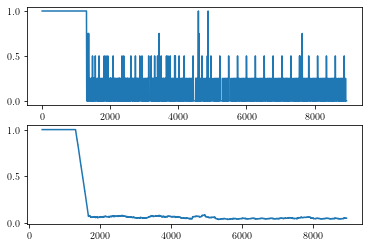

In [8]:
#4 day rolling average 
fig, axs = plt.subplots(2)
(yield_curve.iloc[:,1:] == 0).any(axis = 1).astype(float).rolling(4).mean().plot(ax = axs[0]);
(yield_curve.iloc[:,1:] == 0).any(axis = 1).astype(float).rolling(365).mean().plot(ax = axs[1]);

In [9]:
#Map the columns to numeric durations
new_columns = {}
for col in yield_curve.columns[1:]:
    temp = re.findall(r'\d+', col) 
    res = list(map(int, temp)) 
    new_columns[col] = res[0]/100

In [10]:
#Convert Columns to numeric
yield_curve.rename(columns = new_columns, inplace = True)

### Remove the missing rows and the missing square and plot the yield curve

In [11]:
yc = yield_curve[(yield_curve != 0).all(axis = 1)]

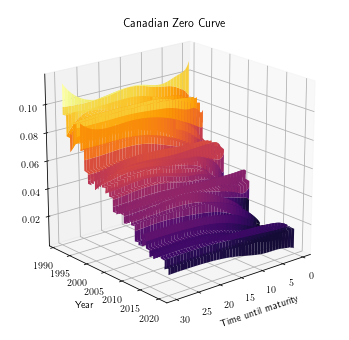

In [12]:
#plot the yield curve
x = yc.columns[1:]
y = yc.Date.dt.year
X,Y = np.meshgrid(x,y)
Z = yc.iloc[:,1:].values
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='inferno')
ax.view_init(20, 50)
plt.xlabel('Time until maturity');
plt.ylabel('Year');
plt.title('Canadian Zero Curve');
#plt.colorbar();
plt.savefig("p1.png", dpi = 350)

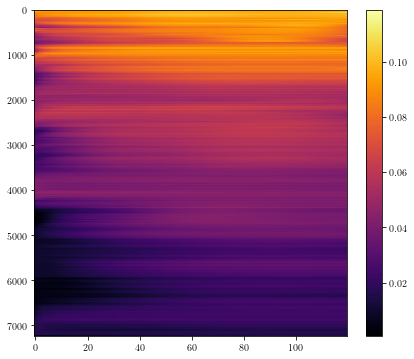

In [13]:
plt.figure(figsize = (7,6))
plt.imshow(yc.iloc[:,1:],aspect='auto',  cmap='inferno');
plt.colorbar();
plt.savefig("p2.png", dpi = 350)

### Fixed Income: Government Bonds and Monetary Policy
#### What are bonds? 
- Face value and Coupon
- An IOU
- Price and yield

####  Government Bonds: 

- 5 year fixed:
- Government bonds are issued by governments to raise money to finance projects or day-to-day operations
- Are safe investments 
- Traded in financial market 

#### Monetary Policy: Overnight Rate:

- https://www.bankofcanada.ca/core-functions/monetary-policy/

#### Fixed Income and Mortgages

- Funding Sources securitization NHA MBS, and covered bonds
- Overnight affects variable rate mortgage
- In both cases, there are spreads between the respective instruments that are dependent on consumer specific competition
- For example . . . 
### Why Model Zero Coupon Bonds

Bolder ''The most fundamental underlying driver of fixed-income securities’ returns is the
sovereign yield curve.'

Bolder: ''Simply plotting the YTM for a selection of bonds would be misleading. Firstly, the YTM
measure, which is a complicated average of zero-coupon rates, cannot be used to discount a single
cash flow. In fact, the YTM cannot be used to price any set of bonds apart from the specific bond
to which it refers. Secondly, the implicit reinvestment assumption and the coupon effect make the
YTM measure extremely difficult to interpret as a yield curve.''

### PCA analysis as per Meucci - Risk and Asset Allocation
Let $Y_t^{v}$ represent the yield to maturity (i.e the yield curve) then changes in the yield to maturity $X^{v}_t = Y^{v}_{t} - Y^{v}_{t-1}$ form the set of random variables that are approximately iid. 


In [14]:
N_start = 1465+int(5*365*5/7.47) #start index
N = 10 #number of pca factors to store
nn = 3 #number of pca factors to use for modelling
X = yc.iloc[:,1:].diff()
print(yc.Date.iloc[N_start])
X = X.iloc[N_start:,:]

2001-12-24 00:00:00


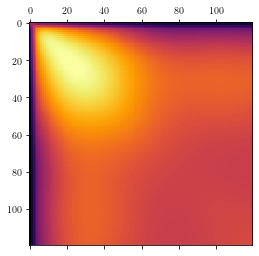

In [15]:
#estimate the covariance matrix 
from sklearn.covariance import EmpiricalCovariance
covX_ = EmpiricalCovariance().fit(X)
plt.matshow(covX_.covariance_, aspect='auto',  cmap='inferno');
covX = covX_.covariance_
plt.savefig("p3.png", dpi = 350)

In [16]:
#PCA 
# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(covX)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
#for i in eig_pairs:
#    print(i[0])

components_ = np.vstack([eig_pairs[i][1] for i in range(N)])
eig_sort = np.vstack([eig_pairs[i][0] for i in range(len(eig_pairs))])

explained_variance_ratio_  =  eig_sort[:N].cumsum()/eig_sort.sum()

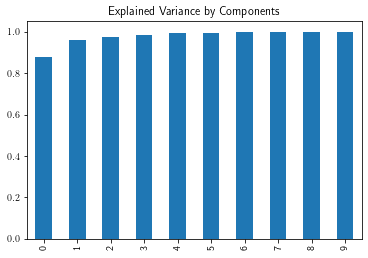

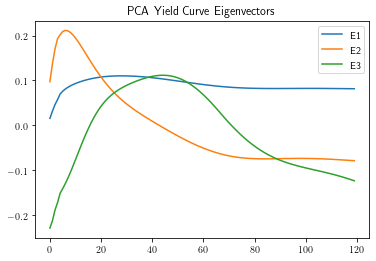

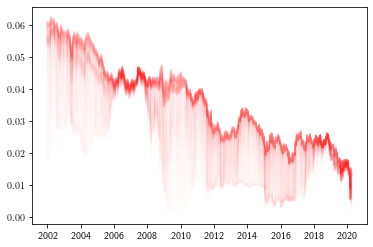

In [78]:
#Variance explained by the first three components 
explained_variance_ratio_[:3]
pd.DataFrame(explained_variance_ratio_).plot.bar(legend = False, title = "Explained Variance by Components");
plt.savefig("ExplainedVar.png", dpi = 300)
pd.DataFrame(components_[0:3], index = ["E1", "E2", "E3"]).transpose().plot(title = "PCA Yield Curve Eigenvectors");
plt.savefig("YieldCurveFactors.png", dpi = 300)
plt.figure();
plt.plot(yc.Date.iloc[N_start:], yc.iloc[:,1:].iloc[N_start:], color = 'red', alpha = 0.01);

The matrix of eigen-values
$E = (e^{1}, ..., e^{n})$

The factors
$F = (X - \mathbb{E}[X])E $

Then 
$X \approx F E^\intercal$

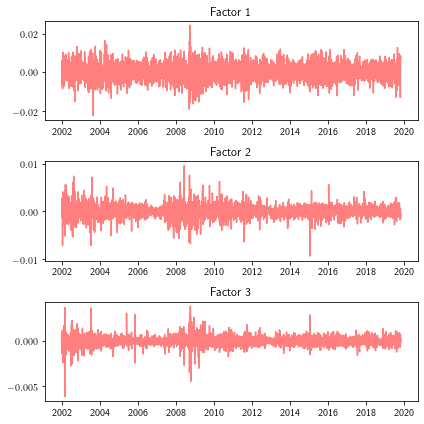

In [96]:
E = components_[0:3].transpose()
F = np.matmul((X - X.mean()).values, E)
fig, axs = plt.subplots(3, figsize = (6,6))
#Showing pre corona virus for visual clarity
axs[0].set_title('Factor 1')
axs[0].plot(yc.Date.iloc[N_start:-100], F[:-100,0], color = 'red', alpha = 0.5, label = "F1");
axs[1].set_title('Factor 2')
axs[1].plot(yc.Date.iloc[N_start:-100], F[:-100,1],color = 'red', alpha = 0.5, label = "F2");
axs[2].set_title('Factor 3')
axs[2].plot(yc.Date.iloc[N_start:-100], F[:-100,2],color = 'red', alpha = 0.5, label = "F3");
plt.tight_layout()
plt.savefig("Factors_time.png", dpi = 300)

In [19]:
E.shape

(120, 3)

In [20]:
F.shape

(4547, 3)

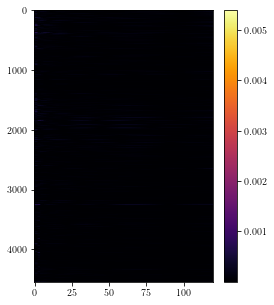

In [21]:
X_ = np.matmul(F, E.transpose())
plt.figure(figsize = (4,5))
plt.imshow(np.abs(X.values - X_),aspect='auto',  cmap='inferno');
plt.colorbar();

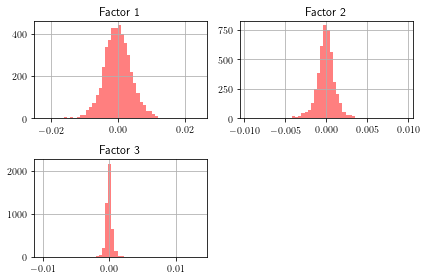

In [98]:
pd.DataFrame(F, columns = ["Factor 1", "Factor 2", "Factor 3"]).hist(bins = 50, color = 'red', alpha = 0.5)
plt.title("Factor Distributions")
plt.tight_layout();
plt.savefig("Factor Distribution.png")

### Correlation with Average Benchmark Rate

In [23]:
benchmarks.head()

,Date,Overnight Target Rate,3-mth T-Bill Rate,2-yr Govt. Bond Yield,5-yr Govt. Bond Yield,10-yr Govt. Bond Yield,30-yr Govt. Bond Yield
0,2001-12-07,2.25,2.04,3.49,4.83,5.53,5.76
1,2001-12-10,2.25,2.02,3.34,4.73,5.48,5.73
2,2001-12-11,2.25,2.00,3.28,4.67,5.43,5.69
3,2001-12-12,2.25,2.00,3.26,4.65,5.40,5.65
4,2001-12-13,2.25,2.02,3.34,4.73,5.47,5.70


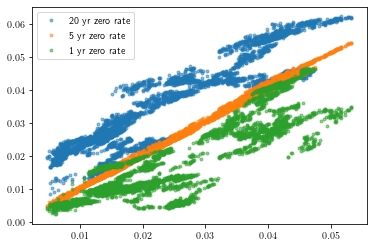

In [24]:
data = pd.merge(yc, benchmarks, left_on='Date', right_on = 'Date', how = 'inner');
zcb_cols = [i for i in data.columns if type(i) == float]
bond_cols = [i for i in data.columns if type(i) != float and i != 'Date']
data[bond_cols] = data[bond_cols]/100
plt.plot(data['5-yr Govt. Bond Yield'], data[20.0], '.', alpha = 0.5, label = "20 yr zero rate");
plt.plot(data['5-yr Govt. Bond Yield'], data[5.0], '.', alpha = 0.5, label = "5 yr zero rate");
plt.plot(data['5-yr Govt. Bond Yield'], data[1.0], '.', alpha = 0.5, label = "1 yr zero rate");
plt.legend();

zcb_cols = [i for i in data.columns if type(i) == float]
bond_cols = [i for i in data.columns if type(i) != float and i != 'Date']

In [25]:
bond_cols

['Overnight Target Rate',
 '3-mth T-Bill Rate',
 '2-yr Govt. Bond Yield',
 '5-yr Govt. Bond Yield',
 '10-yr Govt. Bond Yield',
 '30-yr Govt. Bond Yield']

### First derive some intuition as to why the benchmark yields are approximately a linear combination of zero rates

All government bonds can be expressed as a combination of zero coupon bonds. Since, the benchmark bonds are an aggregate pool of traded bonds and are agreed upon by the market to represent the benchmark it is assumed that the price of the bond is given by some combination of zero coupon bonds. Assume that the benchmark bond trading at price $P_t$ has cashflows $\alpha_i$ at times $i = 1,...,N$ in the future - then the yield $r$ is the interest rate that makes the discounted cashflows equal to the price. Since the bond is a portfolio of zero coupon bonds:

\begin{equation}
\sum_i \alpha_i e^{-ir} = \sum_i \alpha_i e^{-iY^{(i)}}
\end{equation}

Using the first order taylor approximation: $e^{-ir} \approx 1 - ir $, implies 

\begin{equation}
r \sum_i i\alpha_i  = \sum_i iY^{(i)}\alpha_i \implies r = \sum_i \beta_i Y^{(i)}
\end{equation}

where $\beta_i = \frac{i \alpha_i}{\sum_i i \alpha_i} $

Therefore, the benchmark bond yields are approximately linear combinations of the zero yields. 

### Use the linear approximation/assumption to derive the yield changes in terms of the PCA factors

The benchmarks $R_t \in \mathbb{R}^b$ can be written as: $A^\intercal Y_t$ where $A \in \mathbb{R}^{v \times b}$, and $Y_t \in \mathbb{R}^v$ is the vector of zero yields

Therefore, $R_t - R_{t-1} = A^\intercal (Y_t - Y_{t-1} ) = A^\intercal (X_t) = A^\intercal( \sum_{i=1}^k e_i F^{i}_t) = \sum_{i=1}^k (A^\intercal e_i) F^{i}_t $

### Estimation using Least Squares 

For a given benchmark $k$, column  $a_k$ can be estimated using least squares using lasso regularized regression

In [26]:
model = False

def estimate_bond_zcb(col_name, zcb_cols, data, plt_flag = 0):
    'this function trains a lasso regression on the first half of the dataset'
    X =  100*data[zcb_cols]
    y =  100*data[col_name]
    hw = len(y)//2
    X_train = X.iloc[:hw,:]
    y_train = y.iloc[:hw]

    lasso = Lasso(random_state=0, max_iter=10000, fit_intercept=False)
    alphas = np.logspace(-4, -1, 10)

    tuned_parameters = [{'alpha': alphas}]
    n_folds = 5

    clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=True, scoring = 'r2')
    clf.fit(X_train, y_train)
    scores = clf.cv_results_['mean_test_score']
    scores_std = clf.cv_results_['std_test_score']
    
    if plt_flag:
        plt.figure().set_size_inches(8, 6)
        plt.semilogx(alphas, scores)

        # plot error lines showing +/- std. errors of the scores
        std_error = scores_std / np.sqrt(n_folds)

        plt.semilogx(alphas, scores + std_error, 'b--')
        plt.semilogx(alphas, scores - std_error, 'b--')

        # alpha=0.2 controls the translucency of the fill color
        plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

        plt.ylabel('CV $R^2$ +/- std error')
        plt.xlabel('alpha')
        plt.axhline(np.max(scores), linestyle='--', color='.5')
        plt.xlim([alphas[0], alphas[-1]])
    
    return clf

if model:
    benchmark = {}
    for col in bond_cols:
        if col != 'Overnight Target Rate':
            benchmark[col] = estimate_bond_zcb(col, zcb_cols, data)
else:
    with open("benchmark_models.pkl", 'rb') as f:
        benchmark = pickle.load(f)

In [27]:
import pickle
with open("benchmark_models.pkl", 'wb') as f:
    pickle.dump(benchmark, f)

3-mth T-Bill Rate Linear Model Out of Sample R2:  0.9747279544532022
2-yr Govt. Bond Yield Linear Model Out of Sample R2:  0.9982043142320964
5-yr Govt. Bond Yield Linear Model Out of Sample R2:  0.9919700045735047
10-yr Govt. Bond Yield Linear Model Out of Sample R2:  0.9920326096409087
30-yr Govt. Bond Yield Linear Model Out of Sample R2:  0.9919947123585225


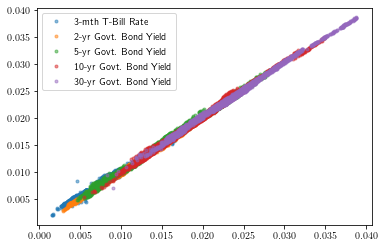

In [28]:
for col in bond_cols:
    if col != 'Overnight Target Rate':
        y_pred = benchmark[col].best_estimator_.predict(data[zcb_cols])
        hw = len(y_pred)//2
        r2_oos = r2_score(data[col].iloc[hw:], y_pred[hw:])
        plt.plot(y_pred[hw:], data[col].iloc[hw:],'.', label = col, alpha = 0.5)
        print(col+ " Linear Model Out of Sample R2: ", r2_oos)
        plt.legend();

### The linear regression approximation is good

In [29]:
## do they all sum to one?
for col in bond_cols:
    if col != 'Overnight Target Rate':
        print(np.sum(benchmark[col].best_estimator_.coef_))

0.9819173957211692
1.0019546425141475
1.0101152064845698
1.0080992909655437
1.0091064643521168


### ZCB Weightings across tenors

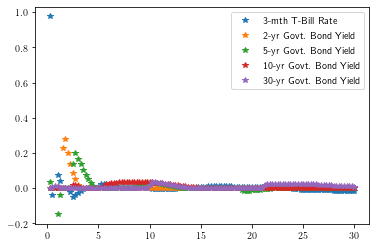

In [30]:
for col in bond_cols:
    if col != 'Overnight Target Rate':
        plt.plot(zcb_cols, benchmark[col].best_estimator_.coef_,'*', label = col)
        plt.legend();

In [31]:
benchmark[col].best_estimator_.coef_.shape

(120,)

In [32]:
#Assemble the A matrix 
A = np.vstack([benchmark[col].best_estimator_.coef_ for col in bond_cols if col != 'Overnight Target Rate' ])

### Finally: given the following equations

$R_t - R_{t-1} = \sum_{i=1}^k (A^\intercal e_i) F^{i}_t$

$Y_t - Y_{t-1} =  \sum_{i=1}^k e_i F^{i}_t$

the key is to simulate the factors $F$ using a stochastic process and project the distribution to some time horizon $\tau$

### Monte Carlo
Hagenbjörk, Meucci, and Litterman either show or assume a zero mean process for the PCA factors. I will do the same. How to select the distribution: maybe use the R package to do this? 

#### Model # 1: Random Walks

$F_t = \sigma \epsilon_t$

#### Model # 2: Volatility Clustering

$F_t = \sigma_t \epsilon_t$


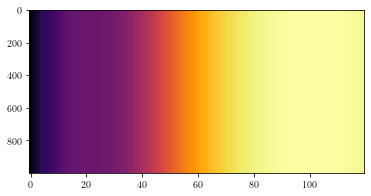

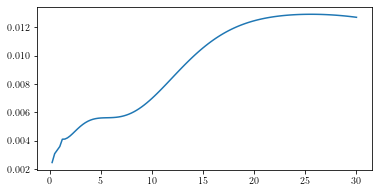

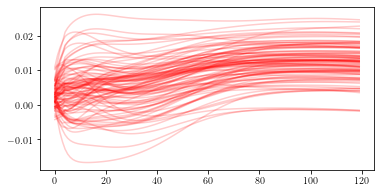

In [33]:
#Model 1: Note the variance is the eigenvalues
tau = 252
N_rep = 1000
start_date = data.Date.iloc[-1]+BDay(1)
end_date = data.Date.iloc[-1]+BDay(tau)
date_grid = pd.bdate_range(start_date,end_date)
def RW(tau, N_rep, F, E, data, zcb_cols, bond_cols, plots = False): 
        #estimation
    eigen_values = pd.DataFrame(F, columns = ["F1", "F2", "F3"], index = X.index).var()

    y_end = data[zcb_cols].iloc[-1,:].values*np.ones([N_rep, len(zcb_cols)])
    y_end = y_end.astype(float)
    benchmark_bond_cols = [x for x in bond_cols if x != 'Overnight Target Rate']
    r_end = data[benchmark_bond_cols].iloc[-1,:].values*np.ones([N_rep, len(benchmark_bond_cols)])
    r_end = r_end.astype(float)

    #sampling/distrubtion selection 
    F_out = np.random.multivariate_normal(np.zeros(len(eigen_values)), np.diag(eigen_values), [tau, N_rep]);
    X_out = np.matmul(F_out, E.transpose())
    X_out_R = np.matmul(X_out, A.transpose())

    Y_out = np.zeros(X_out.shape)
    R_out = np.zeros(X_out_R.shape)

    #projection via random walk
    for t in range(tau):
        if t == 0:
            Y_out[t,:,:] = X_out[t,:,:] + y_end
            R_out[t,:,:] = X_out_R[t,:,:] + r_end
        else:
            Y_out[t,:,:] = X_out[t,:,:] + Y_out[t-1,:,:]
            R_out[t,:,:] = X_out_R[t,:,:] + R_out[t-1,:,:]

    if plots:
        plt.figure(figsize = (6,3))
        plt.imshow(y_end,aspect='auto',  cmap='inferno');
        plt.figure(figsize = (6,3))
        plt.plot(yc.iloc[-1,1:]);
        plt.figure(figsize = (6,3))
        plt.plot(Y_out[tau-1,0:100,:].transpose(), alpha = 0.2, color = 'red');

    return Y_out, R_out

Y_out, R_out = RW(tau, N_rep, F, E, data, zcb_cols, bond_cols, plots = True);

### Time Series Exploration

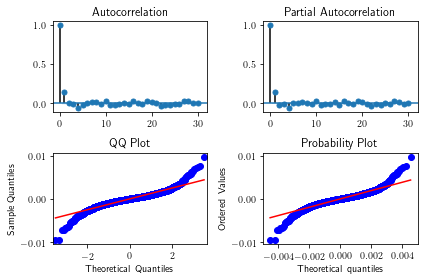

In [68]:
#Model 2: Note the variance follows a garch model


def tsplot(y, name, lags=None, figsize=(6, 4)):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    fig = plt.figure(figsize=figsize)
    #mpl.rcParams['font.family'] = 'Ubuntu Mono'
    layout = (2, 2)
    #ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))
    qq_ax = plt.subplot2grid(layout, (1, 0))
    pp_ax = plt.subplot2grid(layout, (1, 1))

    #y.plot(ax=ts_ax)
    #ts_ax.set_title('Time Series Analysis Plots')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')        
    scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
    plt.tight_layout()
    plt.savefig(name, dpi = 300)
    return 

tsplot(F[:,1], 'NormalQQ.png',lags=30)

### Garch Model Selection 

$$\begin{align}
F^{k}_t & =  \epsilon_t  \label{garch} \\ 
\epsilon_t & =  \sigma_t e_t \\ 
\sigma_{t}^{\lambda}& =\omega + \sum_{i=1}^{p}\alpha_{i}\left|\epsilon_{t-i}\right|^{\lambda} \\ & +\sum_{j=1}^{o}\gamma_{j}\left|\epsilon_{t-j}\right|^{\lambda} I\left[\epsilon_{t-j}<0\right]+\sum_{k=1}^{q}\beta_{k}\sigma_{t-k}^{\lambda} \label{garch1}
\end{align}$$




## Reading the source code...
### code below is the same as:
        res.conditional_volatility
### the code below:
        sigma2 = np.zeros_like(res.resid)
        from arch.utility.array import ensure1d
        
        params = ensure1d(res.params, "params", False)
                            sigma2 = am.volatility.compute_variance(params, 
                            resids = res.resid, sigma2 = sigma_2, 
                            backcast=am.volatility.backcast(res.resid),
                            var_bounds=am.volatility.variance_bounds(res.resid))
        
        sigma2**0.5

    def cpt_losses(am, res):
        lls = -0.5 * (log(2 * np.pi) + log(sigma2) + resids ** 2.0 / sigma2)

### Model Selection
For each independent factor - capture the intertemporal effects via Garch modelling 

* test against student vs normal distribution 
* and values of $(p,o,q) \in \{1,2,3,4\} \times \{0,1,2,3\} \times \{1,2,3,4 \}$

The models are estimated on the first half of the observations and predictions are made for the second half.
Finally, losses are constructed from these predictions.

using the model selection approach pioneered by Hansen https://onlinelibrary.wiley.com/doi/full/10.1002/jae.800

In [51]:
def compute_garch_model(split, scaledF, p, o, q, dist, plots = False):
    
    am = arch_model(scaledF)
    am = ZeroMean(scaledF)
    am.volatility = GARCH(p,o,q)
    am.distribution = dist

    res = am.fit(update_freq=5, disp='off', first_obs=0, last_obs=split)
    #print(res.summary())
    #res.plot();
    loss = 0;
    if split < len(scaledF):
        f = res.forecast(start=split+1, horizon=1)
        realized = (scaledF[split+1:]**2)**0.5
        forecasted = f.variance.values**0.5
        forecasted = forecasted[~np.isnan(forecasted)]
        #loss = np.log(forecasted**2) + (realized**2)/(forecasted**2)
        loss = np.abs(forecasted - realized)
    if plots:
        plt.plot(realized,'-');
        plt.plot(forecasted)
        plt.figure()
        print(res.summary())
        res.plot();
        tsplot(res.resid, lags=30)
    return loss, res, am

def compute_constant_loss(scaledF, split):
    realized = (scaledF[split+1:]**2)**0.5
    forecasted = (scaledF[:split]**2)**0.5
    loss = np.abs(forecasted - realized)
    return loss

def generateMCS(scaledF, distributions, ps, os, qs, split, printMCS = False, plotFinalModel = False):
    
    model_num = 0
    losses = []
    Model_lookup = {}
    
    for dist, p, o, q in product(distributions, ps, os, qs):

        loss, res, am = compute_garch_model(split, scaledF, p, o, q, dist, plots = False)
        Model_lookup[model_num] = [dist, p, o, q, dist.name, res.bic]
        losses.append(loss)
        model_num += 1
    lss = np.array(losses).transpose()
    #Adding the constant model in there for good measure
    Model_lookup[model_num] = ['RandomWalk', 0, 0, 0, 'rw', 0]
    loss = compute_constant_loss(scaledF, split)
    losses.append(loss)
    
    lss = np.array(losses).transpose()
    
    #perform the model confidence set procedure 
    alpha = 0.05
    mcs = MCS(lss, size=alpha)
    mcs.compute()
    included = mcs.included
    excluded = mcs.excluded
    if printMCS:
        print('MCS P-values')
        print(mcs.pvalues)
        print('Included')
        print([Model_lookup[model][1:-1] for model in included])
        print('Excluded')
        print([Model_lookup[model][1:-1] for model in excluded])
    
    #select the minimum BIC model for use 
    BICs = [Model_lookup[model][-1] for model_num in included]
    min_model = BICs.index(min(BICs))    
    #get the lowest BIC model info
    [dist, p, o, q] = Model_lookup[min_model][0:4]
    #train the lowest BIC model on the entire dataset
    loss, res, am = compute_garch_model(len(scaledF), scaledF, p, o, q, dist, plots = plotFinalModel)
    return res, am

In [52]:
def generate_simulated_factor(F_i, printsMCS = False, printFinalModel = False):
    
    scaledF= (10**4)*F_i
    split = int(len(F)/2)
    distributions = [Normal(), StudentsT()]
    ps, os, qs = [[1,2], [0,1], [1,2]]

    res, am = generateMCS(scaledF, distributions, ps, os, qs, split, printsMCS, printFinalModel)

    Factor_Sims = np.zeros([N_rep, tau])
    for i in range(N_rep):
        garch_sim = am.simulate(res.params, tau, burn = 0)
        #Factor_Sims[i,:] = ((garch_sim.volatility)**0.5)*garch_sim.errors
        Factor_Sims[i,:] = garch_sim.errors
    return [Factor_Sims.T/(10**4), res, am]

In [53]:
def Garch_Factors(tau, N_rep, F, E, data, zcb_cols, bond_cols, MonteCarloplots = False, printsMCS = False, printFinalModel = False): 
        #estimation
    eigen_values = pd.DataFrame(F, columns = ["F1", "F2", "F3"], index = X.index).var()

    y_end = data[zcb_cols].iloc[-1,:].values*np.ones([N_rep, len(zcb_cols)])
    y_end = y_end.astype(float)
    benchmark_bond_cols = [x for x in bond_cols if x != 'Overnight Target Rate']
    r_end = data[benchmark_bond_cols].iloc[-1,:].values*np.ones([N_rep, len(benchmark_bond_cols)])
    r_end = r_end.astype(float)

    results = []
    models = []
    fs = []
    for i in range(len(eigen_values)):
        [sims, res, am] = generate_simulated_factor(F[:,i], printsMCS, printFinalModel)
        results.append(res)
        models.append(am)
        fs.append(sims)
    F_out = np.moveaxis(np.array(fs), 0, -1)
    
    X_out = np.matmul(F_out, E.transpose())
    X_out_R = np.matmul(X_out, A.transpose())

    Y_out = np.zeros(X_out.shape)
    R_out = np.zeros(X_out_R.shape)

    #projection via random walk
    for t in range(tau):
        if t == 0:
            Y_out[t,:,:] = X_out[t,:,:] + y_end
            R_out[t,:,:] = X_out_R[t,:,:] + r_end
        else:
            Y_out[t,:,:] = X_out[t,:,:] + Y_out[t-1,:,:]
            R_out[t,:,:] = X_out_R[t,:,:] + R_out[t-1,:,:]

    if MonteCarloplots:
        plt.figure(figsize = (6,3))
        plt.imshow(y_end,aspect='auto',  cmap='inferno');
        plt.figure(figsize = (6,3))
        plt.plot(yc.iloc[-1,1:]);
        plt.figure(figsize = (6,3))
        plt.plot(Y_out[tau-1,0:100,:].transpose(), alpha = 0.2, color = 'red');

    return Y_out, R_out, results, models

### Print out the Model Confidence Results

In [54]:
Y_out, R_out, GarchResults, GarchModels= Garch_Factors(tau, N_rep, F, E, data, zcb_cols, bond_cols,  MonteCarloplots = False, printsMCS = True, printFinalModel = False)

MCS P-values
             Pvalue
Model index        
4             0.000
0             0.000
12            0.000
8             0.000
13            0.000
9             0.000
14            0.000
10            0.000
2             0.000
6             0.000
15            0.000
11            0.000
16            0.000
7             0.001
1             0.258
5             0.258
3             1.000
Included
[[1, 0, 2, 'Normal'], [1, 1, 2, 'Normal'], [2, 0, 2, 'Normal']]
Excluded
[[1, 0, 1, 'Normal'], [1, 1, 1, 'Normal'], [2, 0, 1, 'Normal'], [2, 1, 1, 'Normal'], [2, 1, 2, 'Normal'], [1, 0, 1, "Standardized Student's t"], [1, 0, 2, "Standardized Student's t"], [1, 1, 1, "Standardized Student's t"], [1, 1, 2, "Standardized Student's t"], [2, 0, 1, "Standardized Student's t"], [2, 0, 2, "Standardized Student's t"], [2, 1, 1, "Standardized Student's t"], [2, 1, 2, "Standardized Student's t"], [0, 0, 0, 'rw']]
MCS P-values
             Pvalue
Model index        
10            0.000
13            0.0

### Results for the factors

In [55]:
k=0
for res in GarchResults:
    print("Factor: " +str(k+1))
    print(res)
    k+=1

Factor: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -23217.9
Distribution:                  Normal   AIC:                           46441.7
Method:            Maximum Likelihood   BIC:                           46461.0
                                        No. Observations:                 4547
Date:                Sun, Apr 19 2020   Df Residuals:                     4544
Time:                        21:50:57   Df Model:                            3
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega         23.3359     10.754      2.170  3.0

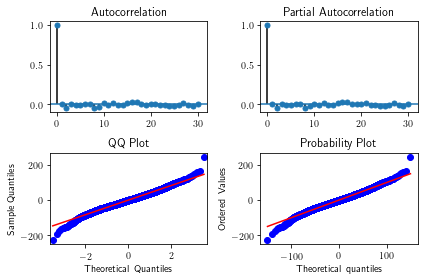

In [67]:
tsplot(GarchResults[0].resid, 'Garch.png',lags=30)

### TD Forecasts

In [57]:
TD #(forecasts as of march) and are end of period

,Year,Quarter,3-mth T-Bill Rate,2-yr Govt. Bond Yield,5-yr Govt. Bond Yield,10-yr Govt. Bond Yield,30-yr Govt. Bond Yield,10-yr-2-yr Govt Spread,Quarter End Date
0,2020,Q1,0.0040,0.0040,0.0050,0.0065,0.0100,0.0025,03/31/2020
1,2020,Q2,0.0015,0.0050,0.0060,0.0075,0.0105,0.0031,06/30/2020
2,2020,Q3,0.0015,0.0065,0.0075,0.0090,0.0115,0.0025,09/30/2020
3,2020,Q4,0.0015,0.0080,0.0090,0.0105,0.0130,0.0025,12/31/2020
4,2021,Q1,0.0015,0.0100,0.0110,0.0125,0.0150,0.0025,03/31/2021
5,2021,Q2,0.0028,0.0120,0.0130,0.0145,0.0170,0.0025,06/30/2021
6,2021,Q3,0.0053,0.0135,0.0145,0.0160,0.0185,0.0025,09/30/2021
7,2021,Q4,0.0078,0.0150,0.0160,0.0175,0.0200,0.0025,12/31/2021


### Relative Entropy Calibration using Covid 19 Forecasts
Given the simulations over $\tau$ for the benchmark rates, the question is how can one incorporte expertise into the simulations? One approach that has been used is to assign probabilities to each simulation and minimally distort them to meet the constraints imposed by expertise. The measure of probability distortion proposed by Avellenada has its roots in information theory and allows for a tractable solution for the twisted measure via duality.

That is, for a given initial distribution $\mathbb{P}_0 \in \mathcal{P}$ the problem is:

$$\begin{align}
\min_{\mathbb{P} \in \mathcal{P}}& \mathbb{E}^{\mathbb{P}}[\log(\frac{d\mathbb{P}}{d\mathbb{P}_0})] \\
\text{such that} &  \mathbb{E}^{\mathbb{P}} [G_i] = C_i, \quad i = 1,2,\dots,N
\end{align}$$

Where the $\int G_i(X) f(X) dX = C_i$ corresponds to the moment constraints imposed by prices or in our case expertise. 
Avellenada shows by introducing lagrange parameters that the above optimization is equivalent to:

$$\begin{align}
\min_{\lambda} \log(Z(\lambda)) - \lambda^\intercal C
\end{align}$$

where $Z(\lambda) = \mathbb{E}^{\mathbb{P}_0} [e^ {\lambda^\intercal G}]$ and the optimal density for a given $\lambda$ is $\mathbb{P}_{\lambda} = \frac{1}{Z(\lambda)} \mathbb{P}_0(\omega) e^{\lambda^\intercal G(w)}$

First some notation: Denoting $R_t^{(n)}$ as the benchmark rates for replication $n$, $p_n$ to be the discrete probabilities of rate path $n$, expressing the economist views on rate type $k$ at time $t$ as $\mathbb{E}^\mathbb{P}[R_{kt}] = \bar{r}_{kt}$. Therefore to calibrate the $n$ simulated interest rates the dual problem takes the form:


... 



In [58]:
benchmark_bond_cols = [x for x in bond_cols if x != 'Overnight Target Rate']
data[benchmark_bond_cols]

,3-mth T-Bill Rate,2-yr Govt. Bond Yield,5-yr Govt. Bond Yield,10-yr Govt. Bond Yield,30-yr Govt. Bond Yield
0,0.0204,0.0349,0.0483,0.0553,0.0576
1,0.0202,0.0334,0.0473,0.0548,0.0573
2,0.0200,0.0328,0.0467,0.0543,0.0569
3,0.0200,0.0326,0.0465,0.0540,0.0565
4,0.0202,0.0334,0.0473,0.0547,0.0570
...,...,...,...,...,...
4553,0.0045,0.0059,0.0075,0.0084,0.0134
4554,0.0021,0.0044,0.0062,0.0072,0.0128
4555,0.0022,0.0044,0.0062,0.0075,0.0132
4556,0.0021,0.0042,0.0060,0.0071,0.0132


,index,variable,value
0,2020-04-02,3-mth T-Bill Rate,0.001992
1,2020-04-03,3-mth T-Bill Rate,0.001987
2,2020-04-06,3-mth T-Bill Rate,0.001996
3,2020-04-07,3-mth T-Bill Rate,0.001995
4,2020-04-08,3-mth T-Bill Rate,0.001999
...,...,...,...
1255,2021-03-15,30-yr Govt. Bond Yield,0.011943
1256,2021-03-16,30-yr Govt. Bond Yield,0.011945
1257,2021-03-17,30-yr Govt. Bond Yield,0.011952
1258,2021-03-18,30-yr Govt. Bond Yield,0.011964


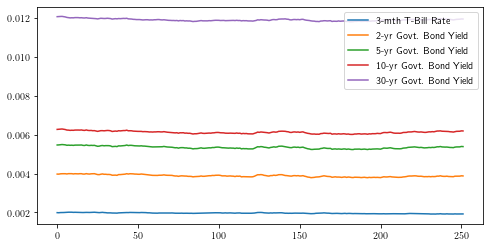

In [59]:
Simulated_Benchmarks = pd.DataFrame(R_out.mean(axis=1), index = date_grid, columns = benchmark_bond_cols)
plt.figure(figsize = (8,4))
plt.plot(R_out.mean(axis=1));
plt.legend(benchmark_bond_cols);
Mean_Rates = Simulated_Benchmarks.reset_index().melt(id_vars=['index'])
Mean_Rates

In [61]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [62]:
## Stack TD forcasts in C
C = TD.melt(id_vars=['Year', 'Quarter', 'Quarter End Date'])
C['Quarter End Date'] = C['Quarter End Date'].astype('datetime64[ns]') 

#C = C[C['variable'] != '3-mth T-Bill Rate']
C = C[C['Quarter End Date'] != '2020-03-31']
C = C[C['Quarter End Date'] <= date_grid.max()]
C['Nearest_Buisness_Day'] = C['Quarter End Date'].apply(lambda x: nearest(date_grid, x))

Constraints = pd.merge(C,Mean_Rates, how = 'inner',  left_on =['Nearest_Buisness_Day', 'variable'], right_on = ['index', 'variable'])

#get indices for the mean computation 
Constrainted_Rates = R_out[date_grid.isin(Constraints['Nearest_Buisness_Day']),:,:]
Constrainted_Rates= np.moveaxis(Constrainted_Rates, 2,0)
Constrainted_Rates = np.reshape(Constrainted_Rates, [Constrainted_Rates.shape[0]*Constrainted_Rates.shape[1],Constrainted_Rates.shape[2]] )
Constrainted_Rates.mean(axis=1)

array([0.00197304, 0.00197635, 0.00193583, 0.00391892, 0.00390156,
       0.00380629, 0.00538514, 0.00535389, 0.00526549, 0.00615752,
       0.00612183, 0.00605871, 0.01193456, 0.0119082 , 0.0118658 ])

In [63]:
Constraints

,Year,Quarter,Quarter End Date,variable,value_x,Nearest_Buisness_Day,index,value_y
0,2020,Q2,2020-06-30,3-mth T-Bill Rate,0.0015,2020-06-30,2020-06-30,0.001973
1,2020,Q3,2020-09-30,3-mth T-Bill Rate,0.0015,2020-09-30,2020-09-30,0.001976
2,2020,Q4,2020-12-31,3-mth T-Bill Rate,0.0015,2020-12-31,2020-12-31,0.001936
3,2020,Q2,2020-06-30,2-yr Govt. Bond Yield,0.0050,2020-06-30,2020-06-30,0.003919
4,2020,Q3,2020-09-30,2-yr Govt. Bond Yield,0.0065,2020-09-30,2020-09-30,0.003902
5,2020,Q4,2020-12-31,2-yr Govt. Bond Yield,0.0080,2020-12-31,2020-12-31,0.003806
6,2020,Q2,2020-06-30,5-yr Govt. Bond Yield,0.0060,2020-06-30,2020-06-30,0.005385
7,2020,Q3,2020-09-30,5-yr Govt. Bond Yield,0.0075,2020-09-30,2020-09-30,0.005354
8,2020,Q4,2020-12-31,5-yr Govt. Bond Yield,0.0090,2020-12-31,2020-12-31,0.005265
9,2020,Q2,2020-06-30,10-yr Govt. Bond Yield,0.0075,2020-06-30,2020-06-30,0.006158


In [64]:
(Constraints.value_y - Constrainted_Rates.mean(axis=1)) ##Proper alignment

0     0.000000e+00
1     8.673617e-19
2    -2.168404e-19
3    -4.336809e-18
4     8.673617e-19
5     4.336809e-19
6    -3.469447e-18
7    -4.336809e-18
8     8.673617e-19
9     0.000000e+00
10    8.673617e-19
11    2.602085e-18
12    5.204170e-18
13    5.204170e-18
14    8.673617e-18
Name: value_y, dtype: float64

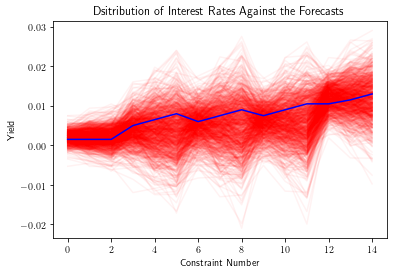

In [66]:
plt.title("Dsitribution of Interest Rates Against the Forecasts")
plt.plot(Constrainted_Rates, 'red', alpha = 0.05);
plt.plot(Constraints.value_x, 'blue');
plt.xlabel("Constraint Number")
plt.ylabel("Yield")
plt.savefig("constraints.png", dpi = 300)

In [91]:
import cvxpy as cp
def min_rel_entropy_primal(R, C):
    
    (m, N) = R.shape
    p = cp.Variable(N)
    epsi = 0.125/100
    #objective = cp.Minimize(cp.square(cp.norm(cp.matmul(cov_half, x),2) + ((delta)**0.5)*cp.norm(x,1)))
    constraints = [p >= 0,
                  cp.sum(p) == 1,
                   R@p <= C+epsi, R@p >= C-epsi ]
    objective = cp.Minimize(cp.sum(cp.kl_div(p, (1/N)*np.ones(N))))
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=True,solver=cp.SCS, max_iters=2000 )
    if p.value is None:
        print("Problem Infeasible")
    return p
p = min_rel_entropy_primal(Constrainted_Rates, Constraints.value_x)


----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 34000
eps = 1.00e-04, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
acceleration_lookback = 0, rho_x = 1.00e-03
Variables n = 2000, constraints m = 5031
Cones:	primal zero / dual free vars: 1
	linear vars: 2030
	exp vars: 3000, dual exp vars: 0
WARN: aa_init returned NULL, no acceleration applied.
Setup time: 1.09e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 8.21e-01  3.24e+00  9.78e-01 -4.15e+01  2.06e+00  2.31e-14  1.77e-02 
   100| 3.78e-04  2.20e-02  6.98e-03 -7.64e-01 -7.82e-01  1.67e-15  3.99e-01 
 

In [92]:
Simulated_Benchmarks

,3-mth T-Bill Rate,2-yr Govt. Bond Yield,5-yr Govt. Bond Yield,10-yr Govt. Bond Yield,30-yr Govt. Bond Yield
2020-04-02,0.001992,0.003977,0.005475,0.006278,0.012082
2020-04-03,0.001987,0.003975,0.005479,0.006286,0.012089
2020-04-06,0.001996,0.003990,0.005490,0.006292,0.012093
2020-04-07,0.001995,0.003996,0.005498,0.006300,0.012097
2020-04-08,0.001999,0.003995,0.005491,0.006287,0.012083
...,...,...,...,...,...
2021-03-15,0.001923,0.003869,0.005375,0.006178,0.011943
2021-03-16,0.001924,0.003871,0.005376,0.006179,0.011945
2021-03-17,0.001925,0.003871,0.005378,0.006183,0.011952
2021-03-18,0.001928,0.003889,0.005399,0.006202,0.011964


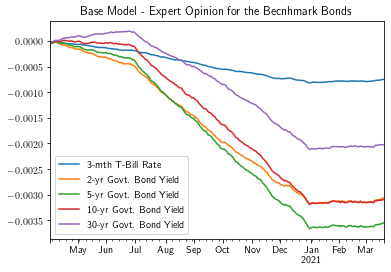

In [93]:
#Simulated_Benchmarks.plot()
Forecasted_Benchmarks = pd.DataFrame(np.matmul(np.moveaxis(R_out, 1,2), p.value), index = date_grid, columns = benchmark_bond_cols)

(Simulated_Benchmarks- Forecasted_Benchmarks).plot(title = "Base Model - Expert Opinion for the Becnhmark Bonds");


# Applications

### Evaluation of the Difference between the short and long rates

Quantile Estimation of Term Shift (a critical quantity in determining the variable vs fixed decision)

Probability that over the next y months 5 year t bill spread exceeds x? 

Probability of duration shift

Caveats

In [179]:
def t_mean_confidence_interval(data,alpha, std_err = 0):
    #If the user specifies a standard error 
    #then the confidence interval will be defined
    #appropriately
    a = 1.0*np.array(data)
    n = len(a)
    if std_err == 0:
        m, se = np.mean(a), np.std(a,ddof=1)
        h = stats.t.ppf(1-alpha/2, n-1)*se/np.sqrt(n)
    else:
        m = np.mean(a)
        h = stats.t.ppf(1-alpha/2, n-1)*std_err
    return m, "+/-", h

def weighted_avg_and_std(values, weights, alpha):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis = 1)
    # Fast and numerically precise:
    variance = np.average(((values.T-average).T)**2, weights=weights, axis = 1)
    
    std = variance**0.5
    n = values.shape[1]
    std_error = std/np.sqrt(n)
    
    h = stats.t.ppf(1-alpha/2, n-1)*std_error
    
    return (average, std, h)
    #return values, average
### Variable vs Fixed Decision
BR = np.moveaxis(R_out, 1,2)

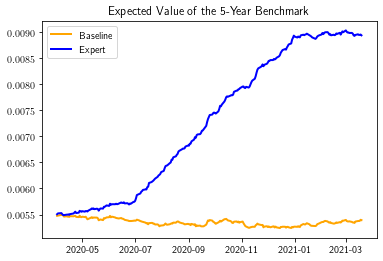

In [181]:
## plotting some paths
import scipy.stats as stats
plt.title("Expected Value of the 5-Year Benchmark")
plt.plot(date_grid,BR[:,2,:].mean(axis=1), alpha = 1, color = 'orange', label = 'Baseline', linewidth = 2);
plt.plot(date_grid, np.matmul(BR[:,2,:], p.value), alpha = 1, color = 'blue', label = "Expert", linewidth = 2);
plt.legend();
plt.savefig("Comparison.png")

### Expected Value of the Variable vs Fixed Incentive

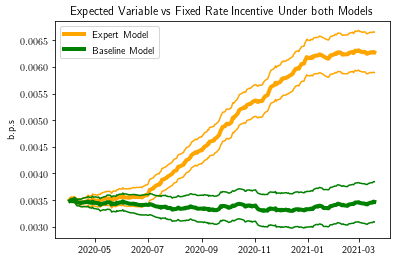

In [236]:
average, std, h = weighted_avg_and_std(BR[:,2,:] - BR[:,0,:], p.value, 0.05)
average_base, std_base, h_base = weighted_avg_and_std(BR[:,2,:] - BR[:,0,:], (1/N_rep)*np.ones_like(p.value), 0.05)

plt.title("Expected Variable vs Fixed Rate Incentive Under both Models")
plt.plot(date_grid, average, color = 'orange', linewidth = 4, label = "Expert Model")
plt.plot(date_grid, average - h, color = 'orange');
plt.plot(date_grid, average + h, color = 'orange');

plt.plot(date_grid, average_base, color = 'green', linewidth = 4, label = "Baseline Model")
plt.plot(date_grid, average_base - h_base, color = 'green');
plt.plot(date_grid, average_base + h_base, color = 'green');
plt.legend();
plt.ylabel("b.p.s")
plt.savefig("FixedvsVariable.png")

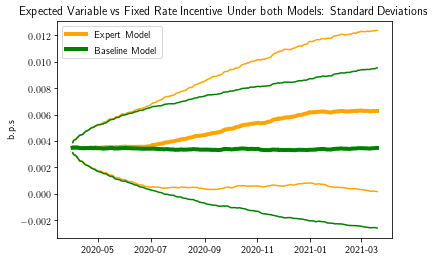

In [237]:
plt.title("Expected Variable vs Fixed Rate Incentive Under both Models: Standard Deviations")
plt.plot(date_grid, average, color = 'orange', linewidth = 4, label = "Expert Model")
plt.plot(date_grid, average - std, color = 'orange');
plt.plot(date_grid, average + std, color = 'orange');

plt.plot(date_grid, average_base, color = 'green', linewidth = 4, label = "Baseline Model")
plt.plot(date_grid, average_base - std_base, color = 'green');
plt.plot(date_grid, average_base + std_base, color = 'green');
plt.legend();
plt.ylabel("b.p.s")
plt.savefig("FixedvsVariable_Standard Deviations.png")

### Expected Value of the Refinancing Incentive (3 year Window)

In [238]:
data.Date.isin(date_grid -  pd.DateOffset(years=3))

0       False
1       False
2       False
3       False
4       False
        ...  
4553    False
4554    False
4555    False
4556    False
4557    False
Name: Date, Length: 4558, dtype: bool

In [239]:
BR[date_grid.isin(five_yr_three_years_ago['LaterDate']),2,:]

array([[ 0.00632813,  0.00474096,  0.00530862, ...,  0.00772153,
         0.00525143,  0.00518466],
       [ 0.00609271,  0.00417249,  0.00492143, ...,  0.00811551,
         0.00471519,  0.00483338],
       [ 0.00623164,  0.00394734,  0.00480783, ...,  0.00789044,
         0.00410222,  0.00525498],
       ...,
       [ 0.00848946,  0.01394503,  0.00221021, ...,  0.00241012,
         0.00814645, -0.00402648],
       [ 0.00810175,  0.01389651,  0.00148851, ...,  0.00324752,
         0.00839807, -0.00432433],
       [ 0.00819888,  0.01318787,  0.00057309, ...,  0.00357817,
         0.00746091, -0.00460875]])

In [240]:
five_yr_three_years_ago = data[data.Date.isin(date_grid -  pd.DateOffset(years=3))][['Date', '5-yr Govt. Bond Yield']]
five_yr_three_years_ago['LaterDate'] = five_yr_three_years_ago['Date'] +  pd.DateOffset(years=3)

indic = date_grid.isin(five_yr_three_years_ago['LaterDate'])

corresponding_BR = BR[indic,2,:]

Refi = -1*(corresponding_BR - np.expand_dims(five_yr_three_years_ago['5-yr Govt. Bond Yield'].values, axis = 1))
Refi.shape

(141, 1000)

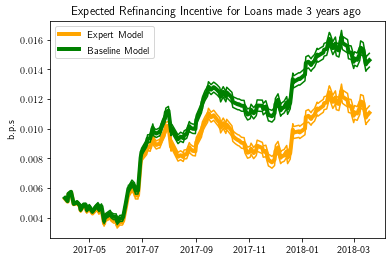

In [243]:
average, std, h = weighted_avg_and_std(Refi , p.value, 0.05)
average_base, std_base, h_base = weighted_avg_and_std(Refi , (1/N_rep)*np.ones_like(p.value), 0.05)

plt.title("Expected Refinancing Incentive for Loans made 3 years ago")
plt.plot(five_yr_three_years_ago['Date'], average, color = 'orange', linewidth = 4, label = "Expert Model")
plt.plot(five_yr_three_years_ago['Date'], average - h, color = 'orange');
plt.plot(five_yr_three_years_ago['Date'], average + h, color = 'orange');

plt.plot(five_yr_three_years_ago['Date'], average_base, color = 'green', linewidth = 4, label = "Baseline Model")
plt.plot(five_yr_three_years_ago['Date'], average_base - h_base, color = 'green');
plt.plot(five_yr_three_years_ago['Date'], average_base + h_base, color = 'green');
plt.legend();
plt.ylabel("b.p.s")
plt.savefig("REFI_hw.png")

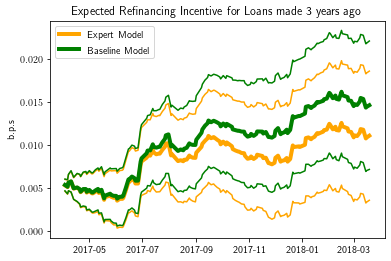

In [242]:
average, std, h = weighted_avg_and_std(Refi , p.value, 0.05)
average_base, std_base, h_base = weighted_avg_and_std(Refi , (1/N_rep)*np.ones_like(p.value), 0.05)

plt.title("Expected Refinancing Incentive for Loans made 3 years ago")
plt.plot(five_yr_three_years_ago['Date'], average, color = 'orange', linewidth = 4, label = "Expert Model")
plt.plot(five_yr_three_years_ago['Date'], average - std, color = 'orange');
plt.plot(five_yr_three_years_ago['Date'], average + std, color = 'orange');

plt.plot(five_yr_three_years_ago['Date'], average_base, color = 'green', linewidth = 4, label = "Baseline Model")
plt.plot(five_yr_three_years_ago['Date'], average_base - std_base, color = 'green');
plt.plot(five_yr_three_years_ago['Date'], average_base + std_base, color = 'green');
plt.legend();
plt.ylabel("b.p.s")
plt.savefig("REFI.png")

### Conclusion 

Nobody really knows what will happen during these perilous times. I surely do not know but maybe the expert's have a better idea. 